In [8]:
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)
matplotlib.rcParams["figure.dpi"] = 200
from IPython.core.getipython import get_ipython
ip = get_ipython()
if ip != None:
    print("Autoreload active")
    ip.run_line_magic("reload_ext", "autoreload")
    ip.run_line_magic("autoreload", "2")

Autoreload active


### Dataset

In [9]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [10]:
def create_model() -> nn.Sequential:
    model = nn.Sequential(
        # Layer 1
        nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2,
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2,
        ),

        # Layer 2
        nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2,
        ),

        # Layer 3
        nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1,
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2,
        ),      

        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)

        # Layer 4
        nn.Linear(2048, 64),
        nn.ReLU(),

        # Layer 5
        nn.Linear(64, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [11]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [12]:
# Hyperparameters
learning_rate = .001
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
model_adam = create_model()
optimizer_adam = torch.optim.Adam(model_adam.parameters(),
                            lr=0.001)
model_sgd = create_model()
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(),
                            lr=0.02)

### Train model

In [13]:
trainer_adam = Trainer(
  model=model_adam,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer_adam
)
train_loss_dict_adam, test_loss_dict_adam = trainer_adam.train(num_epochs)

trainer_sgd = Trainer(
  model=model_sgd,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer_sgd
)
train_loss_dict_sgd, test_loss_dict_sgd = trainer_sgd.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:10<00:00, 85.80it/s]


OrderedDict([(448, 2.601780482700893), (896, 2.091992344175066), (1344, 1.487234694617135), (1792, 1.0168903810637338), (2240, 0.6034270823001862), (2688, 0.3828292787075043), (3136, 0.37128464238984243), (3584, 0.33581784048250746), (4032, 0.4529049439089639), (4480, 0.29576077844415394), (4928, 0.29756495569433483), (5376, 0.2838491031101772), (5824, 0.22895271437508719), (6272, 0.2403149509004184), (6720, 0.21555898125682557), (7168, 0.2017298936843872), (7616, 0.19699184170791081), (8064, 0.1978441881281989), (8512, 0.1723480916449002), (8960, 0.19263100677302905), (9408, 0.1948487705418042), (9856, 0.13118818402290344), (10304, 0.18312559702566691), (10752, 0.15090820991567203), (11200, 0.17473633800234115), (11648, 0.13878312068326132), (12096, 0.14730715432337352), (12544, 0.15632228233984538), (12992, 0.14663416759244033), (13440, 0.15600232833198138), (13888, 0.09016809506075722), (14336, 0.15524095190422876), (14784, 0.10238642006048135), (15232, 0.12316699592130524), (15680,

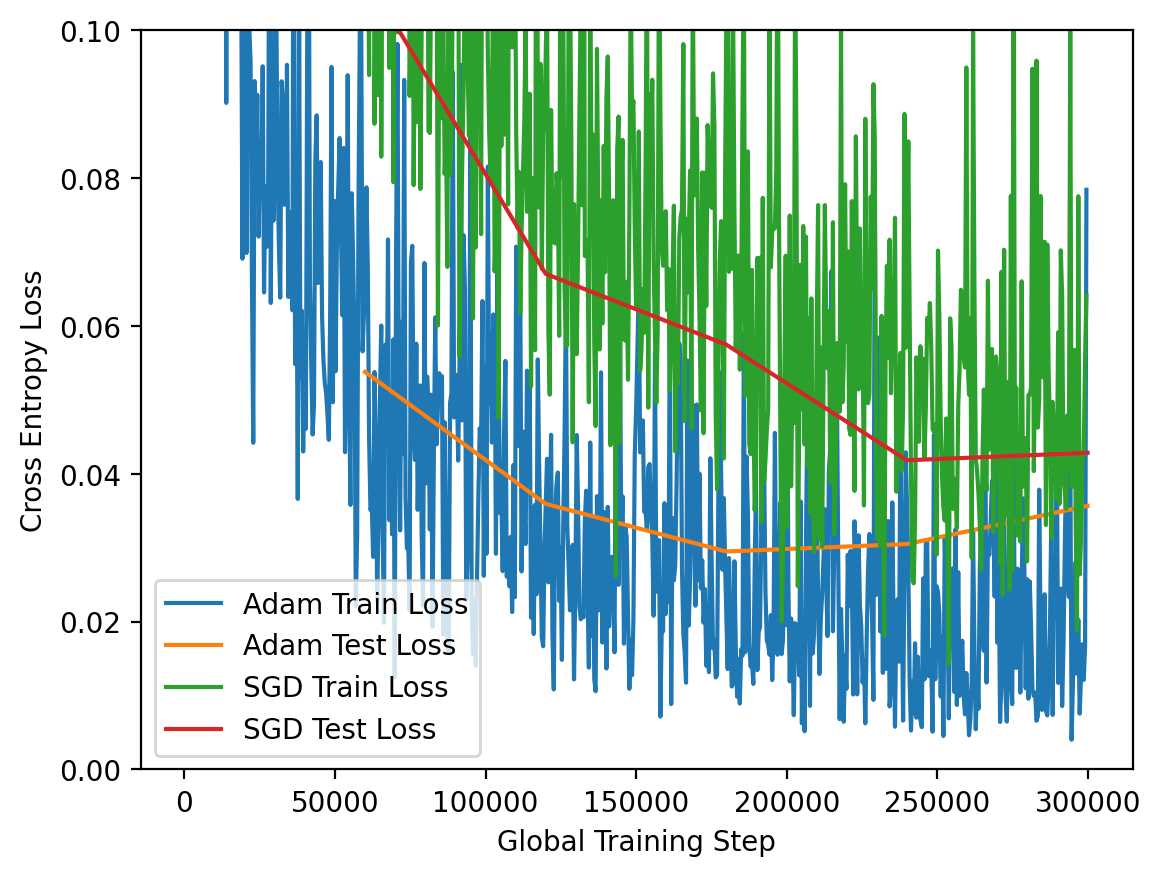

Final Adam Test loss: 0.03565496312053169. Final Adam Test accuracy: 0.9856
Final SGD Test loss: 0.042829393994049794. Final SGD Test accuracy: 0.9856


In [15]:
# We can now plot the training loss with our utility script
print(train_loss_dict_adam)
# Plot loss
utils.plot_loss(train_loss_dict_adam, label="Adam Train Loss")
utils.plot_loss(test_loss_dict_adam, label="Adam Test Loss")
utils.plot_loss(train_loss_dict_sgd, label="SGD Train Loss")
utils.plot_loss(test_loss_dict_sgd, label="SGD Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2b_plot.png"))
plt.show()

final_loss_adam, final_acc_adam = utils.compute_loss_and_accuracy(
    dataloader_test, model_adam, loss_function)
final_loss_sgd, final_acc_sgd = utils.compute_loss_and_accuracy(
    dataloader_test, model_sgd, loss_function)
print(f"Final Adam Test loss: {final_loss_adam}. Final Adam Test accuracy: {final_acc_sgd}")
print(f"Final SGD Test loss: {final_loss_sgd}. Final SGD Test accuracy: {final_acc_sgd}")